### Reconstruct missing data for a more realistic sample

So far, missing values are randomly distributed. This is unrealistic for practical usecases.
Prepare a sample of surface air temparature (SAT) and assume to have data only on specific satellite tracks.

- Can we use the flexibility of our range model to restore complete information?
- If yes, can we visualize selected feature maps to open the black box?

In [1]:
# Tech preamble:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from data_loading import (
    find_data_files, 
    load_data_set, 
    get_anomalies, 
    clone_data, 
    create_missing_mask, 
    split_and_scale_data,
    area_mean_weighted,
    spatial_mask,
)
from models import build_unet_4conv

from keras import backend as K
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511') # nesh
# os.chdir('/Users/mlandt-hayen') # local
# os.chdir('/work') # local in Docker Container

### Load data

In [3]:
## Prepare CESM and FOCI samples:

# Set path CESM and FOCI test data:
path_to_ESM_test_data = 'GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/'

# Load CESM and FOCI test data:
data_CESM = load_data_set(data_path=path_to_ESM_test_data, data_source_name='CESM')
data_FOCI = load_data_set(data_path=path_to_ESM_test_data, data_source_name='FOCI')

# Get anomalies for CESM and FOCI test data:
CESM_anomaly = get_anomalies(feature='surface-air-temperature', data_set=data_CESM)
FOCI_anomaly = get_anomalies(feature='surface-air-temperature', data_set=data_FOCI)

/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [6]:
## Create satellite mask:

# Get number of rows and columns:
n_rows = CESM_anomaly.shape[1]
n_cols = CESM_anomaly.shape[2]

# Initialize mask as ALL missing:
sat_mask = np.zeros((n_rows,n_cols))

# Create 5 stripes:
for s in range(6):
    
    # Loop over rows:
    for r in range(n_rows):
        
        # Store satellite tracks as ONEs:
        sat_mask[r,int(s*24+6+r*0.1):int(s*24+11+r*0.1)] = 1
    
    

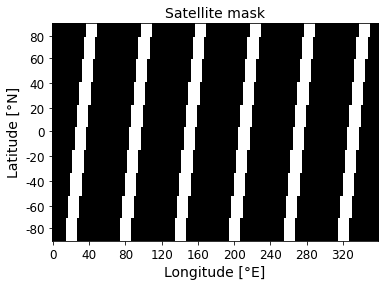

In [7]:
# Show (flipped) satellite mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(sat_mask,axis=0), cmap="gray", interpolation='nearest')#, vmax=0.003)
# cbar = plt.colorbar(im)
# cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Satellite mask', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [8]:
# Check the rate of missing values:
print('missing: ',np.round(1 - np.sum(sat_mask)/np.size(sat_mask),3))

missing:  0.792


In [9]:
# Prepare inputs and targets: Scale to [0,1], use satellite mask:
(
    train_input,
    val_input,
    train_target,
    val_target,
    train_min,
    train_max,
    train_mean,
    train_std,
) = split_and_scale_data(
    data = CESM_anomaly, 
    missing_mask = sat_mask, 
    train_val_split = 1.0, 
    scale_to = 'zero_one')

### Reload range model and restore complete information

In [10]:
# Set paths to final range model:
paths_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sat_CESM_variable_range_0_100_factor_3_final/missing_0_100/model'

# Reload model:
model = tf.keras.models.load_model(Path(paths_to_final_model))

2023-06-13 14:00:16.034987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-06-13 14:00:16.035014: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-13 14:00:16.035031: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neshcl149): /proc/driver/nvidia/version does not exist
2023-06-13 14:00:16.040133: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Get model predictions:
train_pred = model.predict(train_input)

2023-06-13 14:00:17.401406: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


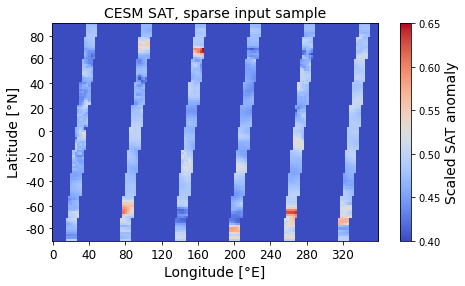

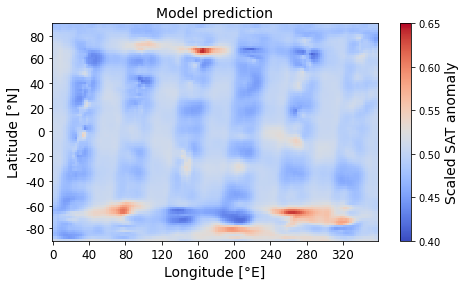

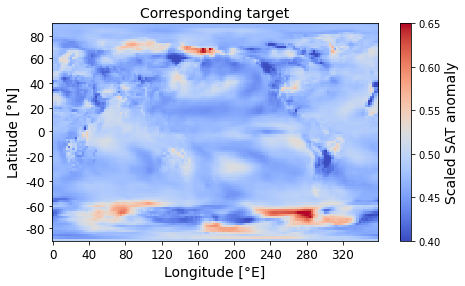

In [12]:
## Plot CESM samples, model predictions and corresponding targets:

# Pick sample:
sample=90

# CESM, sparse input:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(train_input[sample,:,:,0],axis=0), cmap="coolwarm", interpolation='nearest', vmin=0.4, vmax=0.65)
cbar = plt.colorbar(im)
cbar.set_label('Scaled SAT anomaly', fontsize=14)
plt.title('CESM SAT, sparse input sample', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Model prediction:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(train_pred[sample,:,:,0],axis=0), cmap="coolwarm", interpolation='nearest', vmin=0.4, vmax=0.65)
cbar = plt.colorbar(im)
cbar.set_label('Scaled SAT anomaly', fontsize=14)
plt.title('Model prediction', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Corresponding target:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(train_target[sample],axis=0), cmap="coolwarm", interpolation='nearest', vmin=0.4, vmax=0.65)
cbar = plt.colorbar(im)
cbar.set_label('Scaled SAT anomaly', fontsize=14)
plt.title('Corresponding target', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

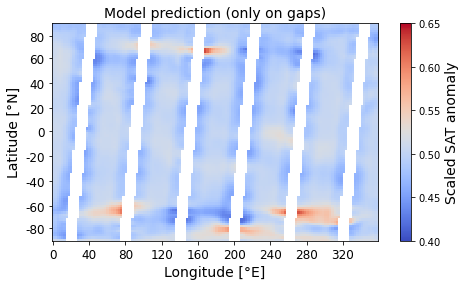

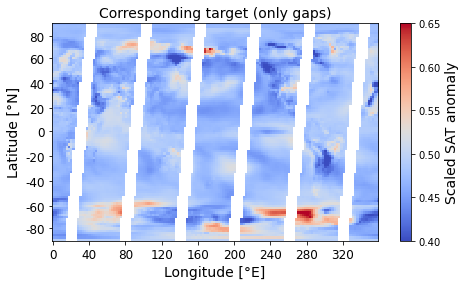

In [13]:
## Now, want to investigate the reconstruction in detail:

# Make a copy of model prediction and true target:
train_pred_copy = np.copy(train_pred[sample,:,:,0])
train_target_copy = np.copy(train_target[sample])

# Set grid points' values to NaN for those grid points, that have been known:
train_pred_copy[sat_mask==1] = float('NaN')
train_target_copy[sat_mask==1] = float('NaN')

# Plot model prediction:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(train_pred_copy,axis=0), cmap="coolwarm", interpolation='nearest', vmin=0.4, vmax=0.65)
cbar = plt.colorbar(im)
cbar.set_label('Scaled SAT anomaly', fontsize=14)
plt.title('Model prediction (only on gaps)', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot corresponding target:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(train_target_copy,axis=0), cmap="coolwarm", interpolation='nearest', vmin=0.4, vmax=0.65)
cbar = plt.colorbar(im)
cbar.set_label('Scaled SAT anomaly', fontsize=14)
plt.title('Corresponding target (only gaps)', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

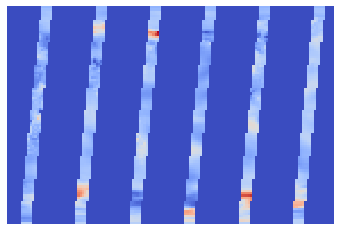

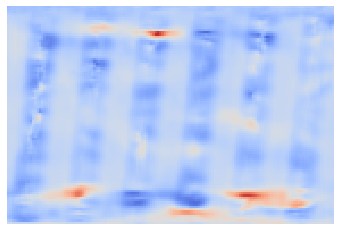

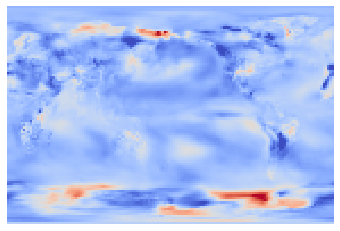

In [73]:
# CESM, sparse input:
fig, ax = plt.subplots()
im = plt.imshow(np.flip(train_input[sample,:,:,0],axis=0), cmap="coolwarm", interpolation='nearest', vmin=0.4, vmax=0.65)
#plt.title('CESM SAT, sparse input sample', fontsize=14)
plt.axis('off')
plt.show()

# Model prediction:
fig, ax = plt.subplots()
im = plt.imshow(np.flip(train_pred[sample,:,:,0],axis=0), cmap="coolwarm", interpolation='nearest', vmin=0.4, vmax=0.65)
#plt.title('Model prediction', fontsize=14)
plt.axis('off')
plt.show()

# Corresponding target:
fig, ax = plt.subplots()
im = plt.imshow(np.flip(train_target[sample],axis=0), cmap="coolwarm", interpolation='nearest', vmin=0.4, vmax=0.65)
#plt.title('Corresponding target', fontsize=14)
plt.axis('off')
plt.show()

In [42]:
model.layers

In [69]:
# # Set layer numbers to consider as output layer for functionalized model:
# out_n = 2

# # Set model input:
# inp = model.input

# # Set model output:
# out = model.layers[out_n].output

# # Combine input and output as new functional model:
# func = K.function([inp], [out])

# # Get output on training data:
# train_out = np.array(func(train_input))

# # Plot selected feature maps for picked sample:

# # Loop over number of feature maps:
# for map_n in range(60):#(train_out.shape[-1]):

#     fig, ax = plt.subplots(figsize=(8,4))
#     im = plt.imshow(np.flip(train_out[0,sample,:,:,map_n],axis=0), cmap="coolwarm", interpolation='nearest')#, vmin=0.4, vmax=0.65)
#     plt.title('Feature map '+str(map_n)+', layer '+str(out_n), fontsize=14)
# #    plt.axis('off')
#     plt.show()

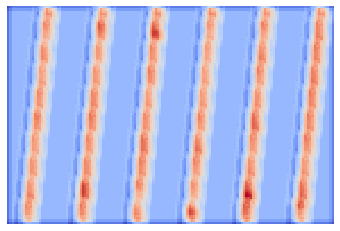

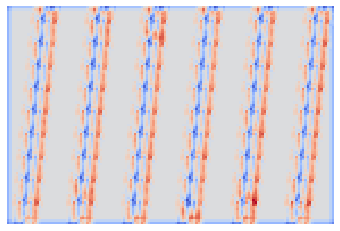

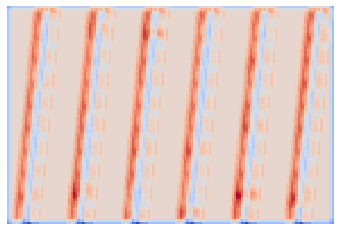

In [74]:
## After first convolution in encoder path:

# Set layer numbers to consider as output layer for functionalized model:
out_n = 2

# Set model input:
inp = model.input

# Set model output:
out = model.layers[out_n].output

# Combine input and output as new functional model:
func = K.function([inp], [out])

# Get output on training data:
train_out = np.array(func(train_input))

# Plot selected feature maps for picked sample:
map_numbers = [1,17,40]

# Loop over map numbers:
for map_n in map_numbers:

    fig, ax = plt.subplots(figsize=(8,4))
    im = plt.imshow(np.flip(train_out[0,sample,:,:,map_n],axis=0), cmap="coolwarm", interpolation='nearest')#, vmin=0.4, vmax=0.65)
#    plt.title('Feature map '+str(map_n)+', layer '+str(out_n), fontsize=14)
    plt.axis('off')
    plt.show()

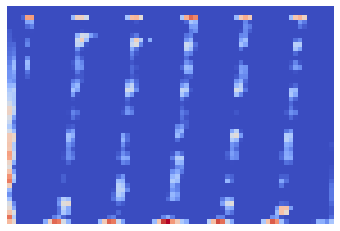

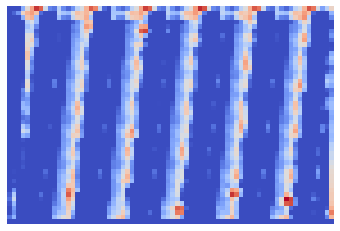

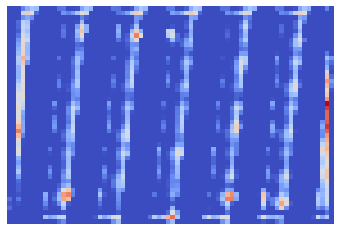

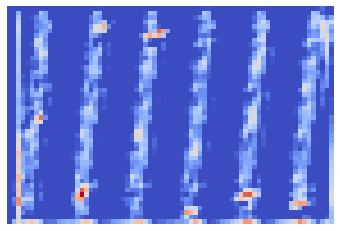

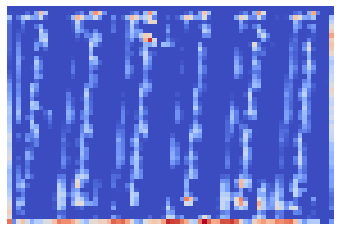

In [75]:
## After second convolution in encoder path:

# Set layer numbers to consider as output layer for functionalized model:
out_n = 5

# Set model input:
inp = model.input

# Set model output:
out = model.layers[out_n].output

# Combine input and output as new functional model:
func = K.function([inp], [out])

# Get output on training data:
train_out = np.array(func(train_input))

# Plot selected feature maps for picked sample:
map_numbers = [2,8,20,35,38]

# Loop over map numbers:
for map_n in map_numbers:

    fig, ax = plt.subplots(figsize=(8,4))
    im = plt.imshow(np.flip(train_out[0,sample,:,:,map_n],axis=0), cmap="coolwarm", interpolation='nearest')#, vmin=0.4, vmax=0.65)
#    plt.title('Feature map '+str(map_n)+', layer '+str(out_n), fontsize=14)
    plt.axis('off')
    plt.show()

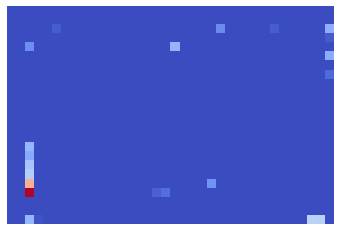

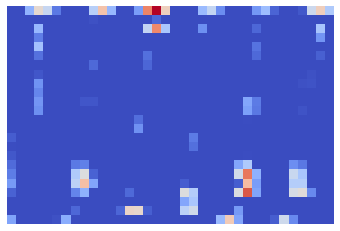

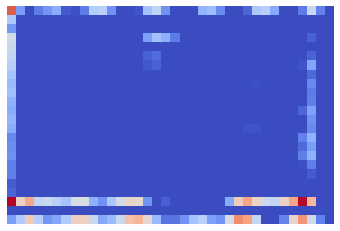

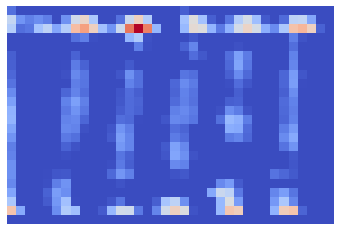

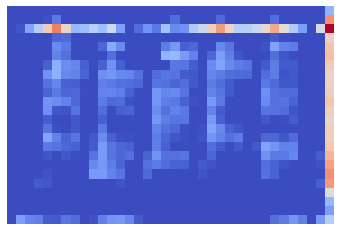

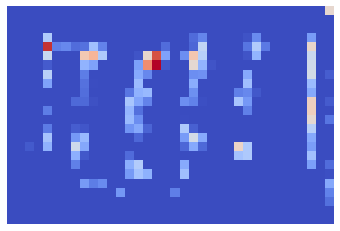

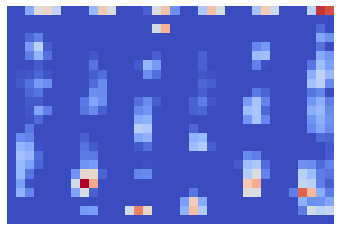

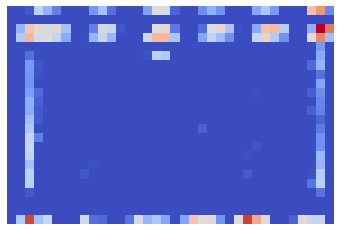

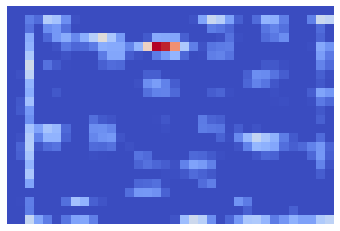

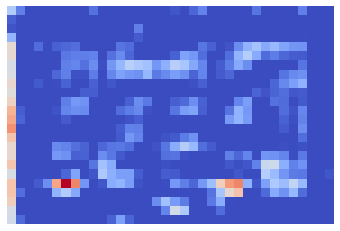

In [76]:
## After third convolution in encoder path:

# Set layer numbers to consider as output layer for functionalized model:
out_n = 8

# Set model input:
inp = model.input

# Set model output:
out = model.layers[out_n].output

# Combine input and output as new functional model:
func = K.function([inp], [out])

# Get output on training data:
train_out = np.array(func(train_input))

# Plot selected feature maps for picked sample:
map_numbers = [2,3,4,9,10,14,16,21,24,25]

# Loop over map numbers:
for map_n in map_numbers:

    fig, ax = plt.subplots(figsize=(8,4))
    im = plt.imshow(np.flip(train_out[0,sample,:,:,map_n],axis=0), cmap="coolwarm", interpolation='nearest')#, vmin=0.4, vmax=0.65)
#    plt.title('Feature map '+str(map_n)+', layer '+str(out_n), fontsize=14)
    plt.axis('off')
    plt.show()

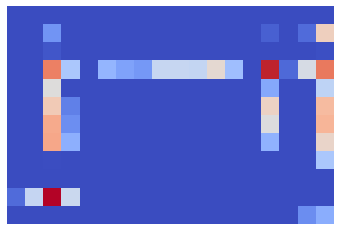

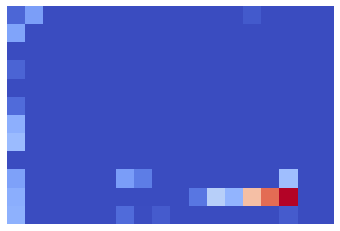

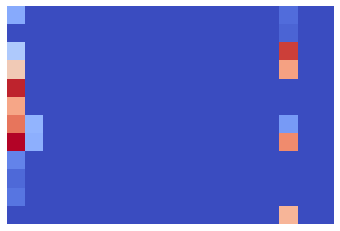

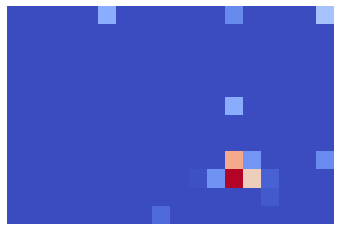

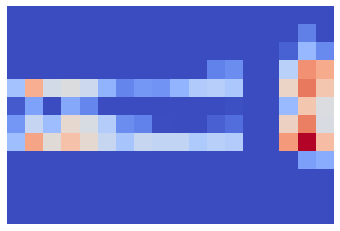

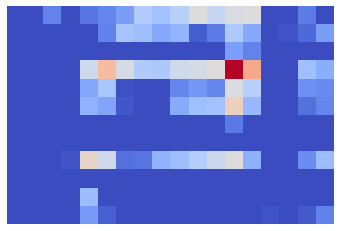

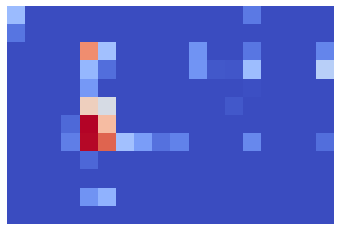

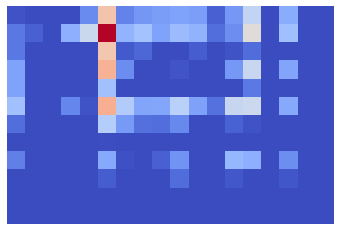

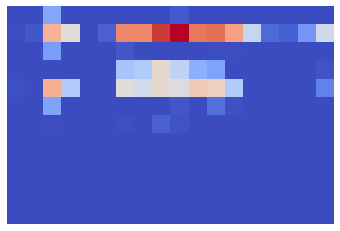

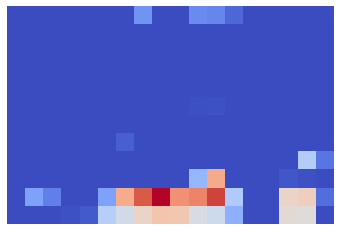

In [77]:
## After fourth (final) convolution in encoder path:

# Set layer numbers to consider as output layer for functionalized model:
out_n = 11

# Set model input:
inp = model.input

# Set model output:
out = model.layers[out_n].output

# Combine input and output as new functional model:
func = K.function([inp], [out])

# Get output on training data:
train_out = np.array(func(train_input))

# Plot selected feature maps for picked sample:
map_numbers = [13,15,16,17,19,23,33,42,52,57]

# Loop over map numbers:
for map_n in map_numbers:

    fig, ax = plt.subplots(figsize=(8,4))
    im = plt.imshow(np.flip(train_out[0,sample,:,:,map_n],axis=0), cmap="coolwarm", interpolation='nearest')#, vmin=0.4, vmax=0.65)
#    plt.title('Feature map '+str(map_n)+', layer '+str(out_n), fontsize=14)
    plt.axis('off')
    plt.show()

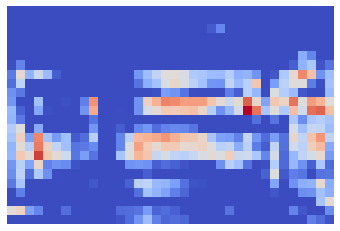

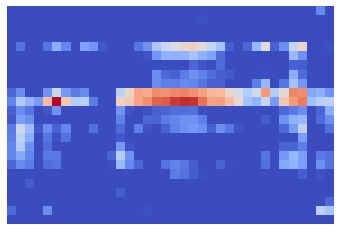

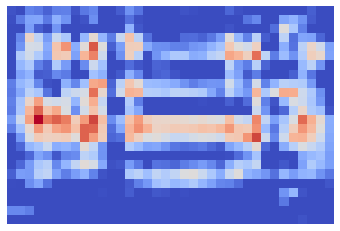

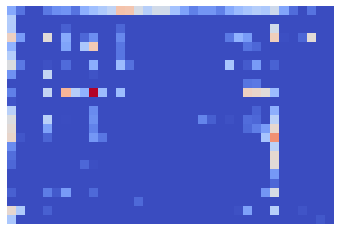

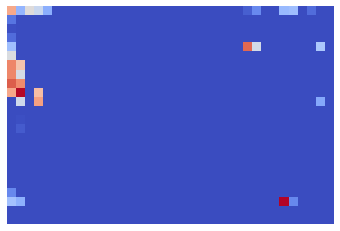

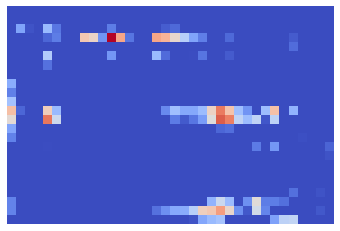

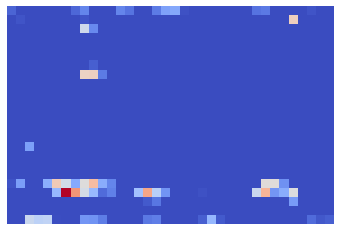

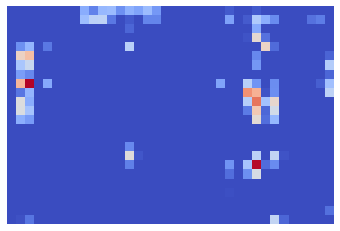

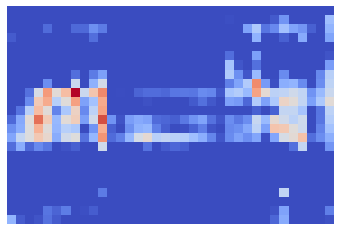

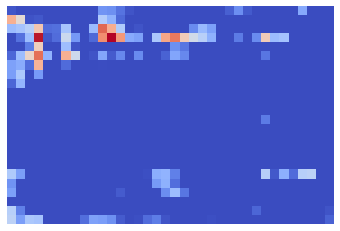

In [78]:
## After first convolution in decoder path:

# Set layer numbers to consider as output layer for functionalized model:
out_n = 15

# Set model input:
inp = model.input

# Set model output:
out = model.layers[out_n].output

# Combine input and output as new functional model:
func = K.function([inp], [out])

# Get output on training data:
train_out = np.array(func(train_input))

# Plot selected feature maps for picked sample:
map_numbers = [31,40,45,47,48,50,51,53,54,56]

# Loop over map numbers:
for map_n in map_numbers:

    fig, ax = plt.subplots(figsize=(8,4))
    im = plt.imshow(np.flip(train_out[0,sample,:,:,map_n],axis=0), cmap="coolwarm", interpolation='nearest')#, vmin=0.4, vmax=0.65)
#    plt.title('Feature map '+str(map_n)+', layer '+str(out_n), fontsize=14)
    plt.axis('off')
    plt.show()

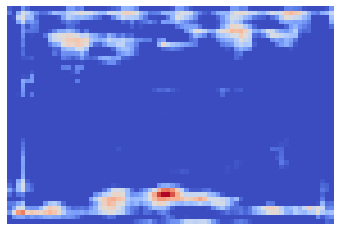

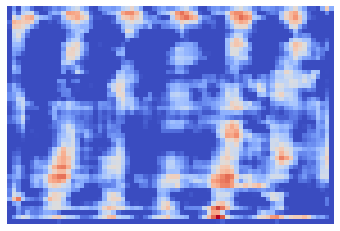

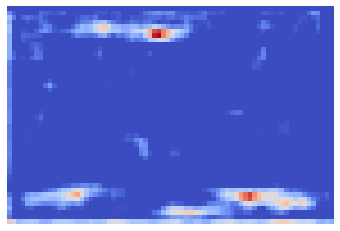

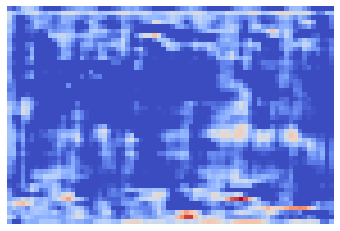

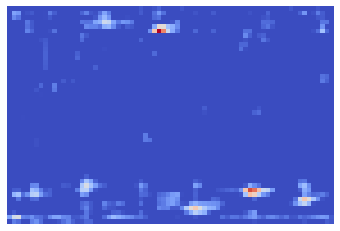

In [79]:
## After second convolution in decoder path:

# Set layer numbers to consider as output layer for functionalized model:
out_n = 19

# Set model input:
inp = model.input

# Set model output:
out = model.layers[out_n].output

# Combine input and output as new functional model:
func = K.function([inp], [out])

# Get output on training data:
train_out = np.array(func(train_input))

# Plot selected feature maps for picked sample:
map_numbers = [5,38,46,55,59]

# Loop over map numbers:
for map_n in map_numbers:

    fig, ax = plt.subplots(figsize=(8,4))
    im = plt.imshow(np.flip(train_out[0,sample,:,:,map_n],axis=0), cmap="coolwarm", interpolation='nearest')#, vmin=0.4, vmax=0.65)
#    plt.title('Feature map '+str(map_n)+', layer '+str(out_n), fontsize=14)
    plt.axis('off')
    plt.show()

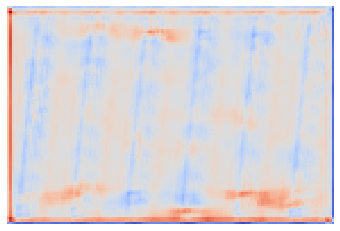

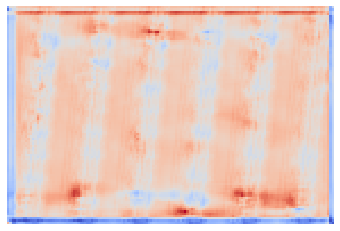

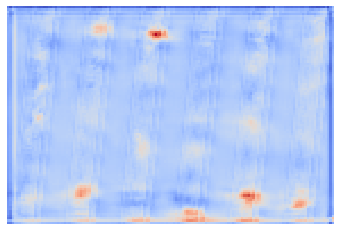

In [80]:
## After third (final) convolution in decoder path:

# Set layer numbers to consider as output layer for functionalized model:
out_n = 23

# Set model input:
inp = model.input

# Set model output:
out = model.layers[out_n].output

# Combine input and output as new functional model:
func = K.function([inp], [out])

# Get output on training data:
train_out = np.array(func(train_input))

# Plot selected feature maps for picked sample:
map_numbers = [17, 34, 38]

# Loop over map numbers:
for map_n in map_numbers:

    fig, ax = plt.subplots(figsize=(8,4))
    im = plt.imshow(np.flip(train_out[0,sample,:,:,map_n],axis=0), cmap="coolwarm", interpolation='nearest')#, vmin=0.4, vmax=0.65)
#    plt.title('Feature map '+str(map_n)+', layer '+str(out_n), fontsize=14)
    plt.axis('off')
    plt.show()